In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchaudio
import whisper
from tqdm.notebook import tqdm

# EDA

In [53]:
class LibriSpeechEDA(torch.utils.data.Dataset):
    """
    Modified version of LibriSpeech class to get raw audio lengths
    """
    def __init__(self, split="test-clean"):
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True,
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        audio, sample_rate, text, _, _, _ = self.dataset[item]
        return audio.shape[1] / sample_rate 

Total samples: 2620
Mean length: 7.42 seconds
Median length: 5.79 seconds
Min length: 1.28 seconds
Max length: 34.95 seconds


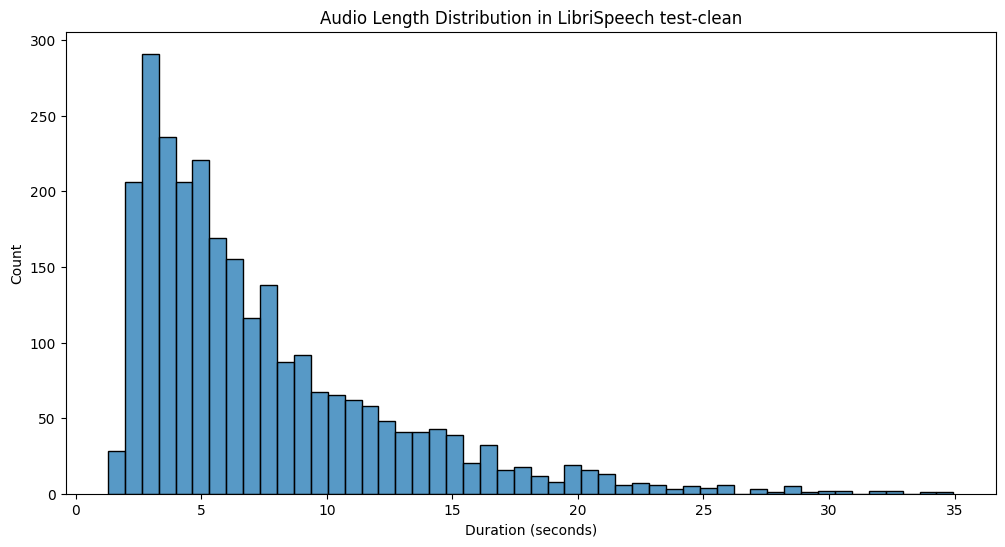

In [54]:
dataset_eda = LibriSpeechEDA("test-clean")
lengths = [dataset_eda[i] for i in range(len(dataset_eda))]

plt.figure(figsize=(12, 6))
sns.histplot(lengths, bins=50)
plt.title('Audio Length Distribution in LibriSpeech test-clean')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')

print(f"Total samples: {len(lengths)}")
print(f"Mean length: {np.mean(lengths):.2f} seconds")
print(f"Median length: {np.median(lengths):.2f} seconds")
print(f"Min length: {np.min(lengths):.2f} seconds")
print(f"Max length: {np.max(lengths):.2f} seconds")

# Whisper

In [75]:
class LibriSpeechWhisper(torch.utils.data.Dataset):
    """
    A simple class to wrap LibriSpeech and trim/pad the audio to 30 seconds.
    It will drop the last few seconds of a very small portion of the utterances.
    """
    def __init__(self, split="test-clean"):
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True,
        )
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        audio, sample_rate, text, _, _, _ = self.dataset[item]
        assert sample_rate == 16000
        audio = whisper.pad_or_trim(audio.flatten()).to(self.device)
        mel = whisper.log_mel_spectrogram(audio)
        return (mel, text)

In [76]:
dataset = LibriSpeechWhisper("test-other")
loader = torch.utils.data.DataLoader(dataset, batch_size=128)

In [78]:
model = whisper.load_model("medium")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

Model is multilingual and has 762,321,920 parameters.


In [79]:
# predict without timestamps for short-form transcription
options = whisper.DecodingOptions(language="en", without_timestamps=True)

In [80]:
predictions = []
gt = []

for mels, texts in tqdm(loader):
    results = model.decode(mels, options)
    predictions.extend([result.text for result in results])
    gt.extend(texts)

  0%|          | 0/23 [00:00<?, ?it/s]

In [84]:
data = pd.DataFrame(dict(predictions=predictions, gt=gt))
data

,predictions,gt
0,"There's iron, they say, in all our blood, And ...",THERE'S IRON THEY SAY IN ALL OUR BLOOD AND A G...
1,"""'Margaret,' said Mr. Hale, as he returned fro...",MARGARET SAID MISTER HALE AS HE RETURNED FROM ...
2,You don't mean that you thought me so silly.,YOU DON'T MEAN THAT YOU THOUGHT ME SO SILLY
3,I really liked that account of himself. Better...,I REALLY LIKED THAT ACCOUNT OF HIMSELF BETTER ...
4,His statement of having been a shop boy was th...,HIS STATEMENT OF HAVING BEEN A SHOP BOY WAS TH...
...,...,...
2934,"Poor Isaac was hurried off accordingly, and ex...",POOR ISAAC WAS HURRIED OFF ACCORDINGLY AND EXP...
2935,The assurance that she possessed some friend i...,THE ASSURANCE THAT SHE POSSESSED SOME FRIEND I...
2936,She gazed accordingly upon a scene which might...,SHE GAZED ACCORDINGLY UPON A SCENE WHICH MIGHT...
2937,"At his feet was placed a table, occupied by tw...",AT HIS FEET WAS PLACED A TABLE OCCUPIED BY TWO...


In [85]:
# WER
import jiwer
from whisper.normalizers import EnglishTextNormalizer

normalizer = EnglishTextNormalizer()

In [86]:
data["predictions_clean"] = [normalizer(text) for text in data["predictions"]]
data["gt_clean"] = [normalizer(text) for text in data["gt"]]
data

,predictions,gt,predictions_clean,gt_clean
0,"There's iron, they say, in all our blood, And ...",THERE'S IRON THEY SAY IN ALL OUR BLOOD AND A G...,there is iron they say in all our blood and a ...,there is iron they say in all our blood and a ...
1,"""'Margaret,' said Mr. Hale, as he returned fro...",MARGARET SAID MISTER HALE AS HE RETURNED FROM ...,margaret said mister hale as he returned from ...,margaret said mister hale as he returned from ...
2,You don't mean that you thought me so silly.,YOU DON'T MEAN THAT YOU THOUGHT ME SO SILLY,you do not mean that you thought me so silly,you do not mean that you thought me so silly
3,I really liked that account of himself. Better...,I REALLY LIKED THAT ACCOUNT OF HIMSELF BETTER ...,i really liked that account of himself better ...,i really liked that account of himself better ...
4,His statement of having been a shop boy was th...,HIS STATEMENT OF HAVING BEEN A SHOP BOY WAS TH...,his statement of having been a shop boy was th...,his statement of having been a shop boy was th...
...,...,...,...,...
2934,"Poor Isaac was hurried off accordingly, and ex...",POOR ISAAC WAS HURRIED OFF ACCORDINGLY AND EXP...,poor isaac was hurried off accordingly and exp...,poor isaac was hurried off accordingly and exp...
2935,The assurance that she possessed some friend i...,THE ASSURANCE THAT SHE POSSESSED SOME FRIEND I...,the assurance that she possessed some friend i...,the assurance that she possessed some friend i...
2936,She gazed accordingly upon a scene which might...,SHE GAZED ACCORDINGLY UPON A SCENE WHICH MIGHT...,she gazed accordingly upon a scene which might...,she gazed accordingly upon a scene which might...
2937,"At his feet was placed a table, occupied by tw...",AT HIS FEET WAS PLACED A TABLE OCCUPIED BY TWO...,at his feet was placed a table occupied by 2 s...,at his feet was placed a table occupied by 2 s...


In [87]:
wer = jiwer.wer(list(data["gt_clean"]), list(data["predictions_clean"]))

print(f"WER: {wer * 100:.2f} %")

WER: 6.04 %


# Ichigo-ASR

In [3]:
class LibriSpeechIchigo(torch.utils.data.Dataset):
    """
    A simple class to wrap LibriSpeech and trim/pad the audio to 30 seconds.
    It will drop the last few seconds of a very small portion of the utterances.
    """
    def __init__(self, split="test-clean"):
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True,
        )
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        audio, sample_rate, text, _, _, _ = self.dataset[item]
        audio = audio.to(self.device)
        assert sample_rate == 16000
        return (audio, text)

In [4]:
dataset = LibriSpeechIchigo("test-clean")
print(len(dataset))

2620


In [5]:
from ichigo.asr import IchigoASR
asr = IchigoASR(config="merge-2560d")

In [ ]:
predictions = []
gt = []

for id in tqdm(range(len(dataset))):
    audio, texts = dataset[id]
    results = asr.transcribe_tensor(audio, chunk_sec=20, overlap_size=1)
    predictions.append(results)
    gt.append(texts)

In [ ]:
import jiwer
from whisper.normalizers import EnglishTextNormalizer

data = pd.DataFrame(dict(predictions=predictions, gt=gt))
data.to_csv('ichigo_c20_o1.csv')

normalizer = EnglishTextNormalizer()

data["predictions_clean"] = [normalizer(text) for text in data["predictions"]]
data["gt_clean"] = [normalizer(text) for text in data["gt"]]
data

In [12]:
data

,duration,predictions,gt,predictions_clean,gt_clean
0,10.435000,"'He hoped there would be stew for dinner, turn...",HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...,he hoped there would be stew for dinner turnip...,he hoped there would be stew for dinner turnip...
1,3.275000,'Stuff it into you.' His belly countered him.,STUFF IT INTO YOU HIS BELLY COUNSELLED HIM,stuff it into you his belly countered him,stuff it into you his belly counseled him
2,6.625000,After early nightfall the yellow lamps would l...,AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...,after early nightfall the yellow lamps would l...,after early nightfall the yellow lamps would l...
3,2.680000,"Hello, Bertie, any good in your mind?",HELLO BERTIE ANY GOOD IN YOUR MIND,hello bertie any good in your mind,hello bertie any good in your mind
4,5.215063,"'Number ten, fresh Nellie is waiting on you. G...",NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...,number 10 fresh nellie is waiting on you good ...,number 10 fresh nelly is waiting on you good n...
...,...,...,...,...,...
2615,10.905000,Oh! to shoot my soul's full meaning into futur...,OH TO SHOOT MY SOUL'S FULL MEANING INTO FUTURE...,0 to shoot my soul is full meaning into future...,0 to shoot my soul is full meaning into future...
2616,14.100000,"Then I, long tried by natural ills, received t...",THEN I LONG TRIED BY NATURAL ILLS RECEIVED THE...,then i long tried by natural ills received the...,then i long tried by natural ills received the...
2617,8.515000,"I love thee freely, as men strive for right. I...",I LOVE THEE FREELY AS MEN STRIVE FOR RIGHT I L...,i love thee freely as men strive for right i l...,i love thee freely as men strive for right i l...
2618,7.540000,I love thee with the passion put to use in my ...,I LOVE THEE WITH THE PASSION PUT TO USE IN MY ...,i love thee with the passion put to use in my ...,i love thee with the passion put to use in my ...


# CSV

In [ ]:
import pandas as pd 
import jiwer

data = pd.read_csv('/root/ichigo/librispeech/ichigo_resultstest-clean/chunk5_overlap0.5.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 0 to 2619
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   duration           614 non-null    float64
 1   predictions        614 non-null    object 
 2   gt                 614 non-null    object 
 3   predictions_clean  614 non-null    object 
 4   gt_clean           614 non-null    object 
dtypes: float64(1), object(4)
memory usage: 28.8+ KB


In [66]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 0 to 2619
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   duration           614 non-null    float64
 1   predictions        614 non-null    object 
 2   gt                 614 non-null    object 
 3   predictions_clean  614 non-null    object 
 4   gt_clean           614 non-null    object 
dtypes: float64(1), object(4)
memory usage: 28.8+ KB


In [67]:
wer = jiwer.wer(list(data["gt_clean"]), list(data["predictions_clean"]))

print(f"WER: {wer * 100:.2f} %")

WER: 14.95 %


# LargeScaleASR

In [18]:
from datasets import load_dataset

dataset = load_dataset(
    "/home/jovyan/aws-s3/tuanlda78202",
    name="medium",  
    split="test"
)
dataset

Resolving data files:   0%|          | 0/6323 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/716 [00:00<?, ?it/s]

Dataset({
    features: ['ID', 'duration', 'wav', 'spk_id', 'sex', 'text'],
    num_rows: 8087
})

In [12]:
dataset[0]

{'ID': '20180911-0900-PLENARY-en_20180911-20:17:50_2',
 'duration': 7.839000225067139,
 'wav': {'bytes': b'RIFF&\xd4\x03\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x10\x00LIST\x1a\x00\x00\x00INFOISFT\r\x00\x00\x00Lavf61.1.100\x00\x00data\xe0\xd3\x03\x00\x98\xff\x95\xff@\x00l\x00\'\x00\xd1\xff\xda\xff5\x00\x19\x00\xcf\xff\xd0\xff\x11\x00\'\x00)\x00\x0c\x00\xc9\xff\xab\xff\x01\x00\x1f\x00\xe6\xff\xc7\xff\xde\xffD\x00`\x00"\x00\xd9\xff\xbf\xff\xf0\xff\x00\x00\x10\x00\x06\x00\r\x00\r\x00\x12\x00\r\x00\xcc\xff\xc9\xff\xdc\xff\x1c\x00V\x00+\x00\xc9\xff\xc5\xff&\x00\x1a\x00\xb4\xff\xa7\xff\x10\x00g\x00W\x00\xf3\xff\xf1\xff\xe5\xff\xca\xff)\x00\n\x00\xc3\xff\xe5\xff"\x00_\x00\x13\x00\xcc\xff\xd1\xff\x0b\x007\x00\xc7\xff\x97\xff-\x00\x82\x00-\x00\xfb\xff\xef\xff\xda\xff\xce\xff\xfb\xff\r\x00\xf4\xff\x0e\x00\x15\x00\x02\x00\xec\xff\xfe\xff\x17\x00\xf9\xff\xef\xff\xe6\xff\xe8\xff\xe4\xff \x00)\x00\xb8\xff\xba\xff\xfe\xff\'\x00\x08\x00 \x00-\x00\x18\x00)\x00\r\x0

In [13]:
from io import BytesIO
import torchaudio

wav_tensor = torchaudio.load(BytesIO(dataset[0]["wav"]["bytes"]))
wav_tensor

(tensor([[-0.0032, -0.0033,  0.0020,  ..., -0.0024,  0.0000,  0.0036]]), 16000)

In [16]:
from IPython.display import Audio
Audio(wav_tensor[0], rate=wav_tensor[-1])